# Identificando importância e explicando a influência nos resutaldos das variáveis nos modelos de curto prazo do IPCA

## Objetivos e motivação

Com o objetivo de aperfeiçoar o método desenvolvido em março para identificar a importância de variáveis (Feature Importance) e selecionar as mais relevantes (Feature Selection) para compor os modelos de curto prazo da GEASE e atender o pedido do executivo da área de executar testes com retiradas de variáveis para verificar performance dos modelos, foi criada essa NOVA metodologia. 

O método aqui exposto ainda usa o modelo de Regressão com penalização (Shrinkage Regression) para seleção de variáveis, que serão usadas nos modelos não-lineares de árvore de decisão (Adaboost, Gradient Boosting e Random Forest). Todavia, a nova abordagem aplica o algoritmo de Recursive Feature Elimination (RFE) com um loop adaptado para executá-lo interativamente por todo o período da amostra. Como modelo de Regressão com penalização, ainda seguimos usado o ElasticNET como opção base do algoritmo de RFE.

Além disso, também foi incorporado método agnóstico de inteligência artificial explicável (XAI) chamado de Shapely Value, baseado na teoria dos jogos cooperativos, para explicar as influências das variáveis nos resutados de previsão dos modelos não lineares (AdaBoost, Gradient Boosting e Random Forest) usados para fazer as previsões na GEASE do IPCA de curto prazo. Em cada etapa explicamos os conceitos aqui mencionados para esclrecimento dos leitores.

# Problema

Embora técnicas de redução, como ElasticNet, sejam frequentemente usadas para selecionar variáveis, é importante observar que as variáveis ​​selecionadas por meio desse método podem variar ao longo do tempo e entre diferentes amostras de dados. Em outras palavras, o número de variáveis ​​escolhidas e a significância atribuída a cada uma delas (medida pelos seus coeficientes) sofre alteração quando se trata de dados de séries temporais. Para abordar esta variabilidade e garantir a identificação de variáveis ​​consistentemente cruciais em múltiplas interações, optamos por criar um método que identificasse as variáveis mais frequentes ​​e influentes (maior coeficiente médio) ao longo do tempo na etapa de seleção de variáveis (Feature Selection). 

Além disso, é crucial identificar como a retirada e inserção de variáveis nos modelos afetam a performance do modelos não lineares que são de fato usados para as projeções mensais na GEASE. Nesse sentido, o método de explicabilidade de inteligência artificial independete de modelo chamado Shapley Value atende essa necessidade. Os métodos não lineares empregados neste trabalho são do tipo "Black Box" sendo difícies de explicar por vezes e o Shaley Value sendo um método que independente do modelo torna possível padronizar metodologia de explicabilidade entre diferentes algoritmos.

## Metodologia

Nosso trabalho divide-se em duas partes grandes partes, a primeira implementa a método de seleção de variáveis por meio do Rercursive Feature Elimination (RFE) com o ElasticNet em que a partir de 156 variáveis distintas selecionamos as 30 mais cruciais. Nessa etapa não há projeção propriamente dita pois somente treinamos o ElasticNet em todo o período da amostra, portanto nas 162 observações. 

Selecionadas as variávies na etapa anterior, partimos para segunda etapa que é a projeção propriamente dita. Nela usamos os modelos não-lineares, Adaboost, Gradient Boosting e Random Forest. Com base nas métricas de acurácia, selecionamos o melhor modelo e aplicamos o método Shapley Value para compreender a contribuição das variáveis usadas. 

### Pre-processamento dos dados

O conjunto de dados foi dividido em conjuntos de treinamento e teste. O conjunto de treinamento foi formado pelos 80% iniciais da série e o conjunto de teste foi formado pelos 20% finais da série. Os modelos foram construídos usando os dados de treinamento, enquanto o conjunto de testes foi dedicado para a realização das previsões e a avaliação do desempenho dos modelos.

### Treinamento dos modelos e seleção dos hiperparâmetros

A técnica de validação cruzada para séries temporais (*Time Series Split*) foi utilizada na etapa de treinamento dos modelos. Esta técnica é uma variação da validação cruzada k-*fold*, que permite manter a ordem temporal dos dados durante o processo de validação. Neste procedimento, a série é dividida em vários subconjuntos (*folds*) sequenciais, de modo que cada subconjunto é usado como conjunto de teste uma vez, enquanto os conjuntos anteriores são utilizados como conjuntos de treinamento. Assim, o tamanho do conjunto de treinamento aumenta sequencialmente e o modelo pode ser treinado em quantidades cada vez maiores de dados históricos, permitindo uma avaliação mais precisa das suas capacidades preditivas (PEDREGOSA et al., 2011; AMAT RODRIGO; ESCOBAR ORTIZ, 2023). Os hiperparâmetros dos modelos foram selecionados utilizando *Grid Search*, ou busca em grade, na validação cruzada *Time Series Split*. A Tabela 1 mostra os parâmetros a serem selecionados em cada modelo e os valores do *Grid Search*.

**Tabela 1** - Hiperparâmetros a serem selecionados e os respectivos valores do *Grid Search* para a validação cruzada.

| Hiperparâmetro | Random Forest | Adaptive Boosting | Gradient Boosting | Extreme Gradient Boosting |
|----------------|---------------|----------|--------|------|
| n_estimator    | 50, 100, 150, 200  | 50, 100, 150, 200 | 50, 100, 150, 200 | 50, 100, 150, 200 |
| max_depth      | 3, 5, 10, 15  |   | 3, 5, 10, 15 | 3, 5, 10, 15 |
| learning_rate  |  | 0,001; 0,01; 0,1  | 0,001; 0,01; 0,1 | 0,001; 0,01; 0,1 |

Neste trabalho, usamos a validação cruzada para séries temporais com o *Grid Search* para seleção dos hiperparâmetros e treino e teste dos modelos. O conjunto de validação avançou a cada 5 observações, segundo o parâmetros `val_step` = 5. Com esta configuração, foi utilizado um total de 5 *folds*. Por fim, o melhor modelo foi selecionado segundo o erro absoluto médio (MSE), no caso para descobrir os hiperparametros e  Após selecionados os hiperparâmetros, o modelo foi treinado novamente com os hiperparâmetros selecionados no conjunto de treinamento e validação inteiro, com o parâmetro `refit` = `True`.

### Previsão

A etapa de previsão adotou uma estratégia conhecida como previsão recursiva. Neste procedimento, cada nova previsão se baseia na previsão anterior. Em outras palavras, para a previsão um passo adiante, toda a série é usada como entrada dos modelos. Em seguida, para prever dois passos adiante, o valor previsto um passo a diante também é usado como entrada nos modelos, juntamente com os valores da série. Isso segue até que todas as previsões sejam realizadas. Neste estudo, esta abordagem foi utilizada para realizar previsões no conjunto de teste.

### Avaliação do desempenho

Neste trabalho, foi adotado um conjunto de medidas de precisão das previsões, comumente utilizadas para séries temporais, cada uma avaliando diferentes aspectos do erro cometido pelos modelos de previsão (HYNDMAN; ATHANASOPOULOS, 2018). A avaliação do desempenho dos modelos baseados em árvores de decisão utilizou as seguintes medidas de erro: Erro Quadrático Médio (MSE), Raiz do Erro Quadrático Médio (RMSE), Erro Absoluto Médio (MAE) e Erro Percentual Absoluto Médio (MAPE). 

# Etapa 1 - Seleção de Variáveis (Feature Selection) usando Recursive Feature Elimination (RFE) e ElasticNet

Essa parte do trabalho é dedicada a realizar a seleção de variáveis entre o conjunto total possível. Esse conjunto compreende 156 diferentes variáveis das quais selecionamos as 30 mais frequentes e significantes com base no proceso de RFE mais ElasticNet. Abaixo inciamos explicando os conceitos.

### Eliminação Recursiva de Variáveis (Recursive Feature Elimination - RFE)

O pacote Sklearn do Python oferece uma ferramenta chamada Recursive Feature Elimination (RFE) com a finalidade de realizar testes progressivos com base na retirada de variáveis. O RFE trata-se de loop que executa o modelo desejado diversas vezes removendo as variáveis menos importantes a cada interação, uma por uma, até manter apenas as mais úteis (maiores coeficintes). RFE opera como uma técnica de de variáveis no estilo "wrapper", portanto precisamos dizer a ele qual modelo devemos usar. Em nosso caso estamos usando o ElasticNet.

Assim, após escolher os melhores hiperparâmetros por meio de otimização, treinamos nosso modelo de ElasticNET aplicando o algoritmo RFE fornecido pelo Sklearn para selecionar as variávesi mais frequentes ao longo dos meses. RFE é um exemplo de eliminação retroativa (backward elimination) de variáveis em que primeiro ajustamos nosso modelo usando todas as variáveis do conjunto de dados. Progressivamente, uma por uma, o código remove os recursos (vairáveis) menos significativos, cada vez reajustando o modelo até ficarmos com o número desejado de variáveis. Dois parâmetros de configuração são essenciais nesse método: o número de variáveis a serem selecionadas (optamos por 30 vairáveis) e o algoritmo empregado para seleção delas, no caso é o ElasticNet.

Neste trabalho, aplicamos o algoritmo RFE a um conjunto de dados de 162 observações, ou seja, 162 meses distintos. Empregamos um mecanismo de loop para aplicar RFE de forma incremental, começando com dados dos primeiros seis meses e adicionando um mês a cada interação até que todos os meses fossem incluídos, totalizando 156 interações. Durante cada interação, o algoritmo RFE processou o conjunto de dados, selecionando os 30 recursos mais significativos por meio de um processo de eliminação passo a passo guiado pelo modelo ElasticNet. Essa abordagem interativa nos permitiu identificar os recursos mais significativos em todo o conjunto de dados. A figura abaixo ilustra a aplicação do algoritmo nos conjuntos de dados mensais.

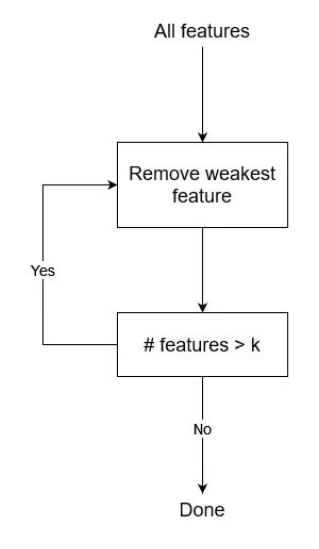

### Modelo ElasticNet para seleção de variáveis (Feature Selection)

De acordo com alguns autores, uma desvantagem dos algoritmos LASSO e Ridge é sua eficácia limitada ao lidar com variáveis ​​altamente correlacionadas. Nos casos em que certas variáveis ​​explicativas apresentam correlações fortes, o estimador LASSO pode tratá-las com indiferença, enquanto o estimador Ridge tende a reduzi-las coletivamente e não eliminá-las. Além disso, conforme mostrado por Wang et al., 2020 em sua simulação, a regularização $l_{1}$ tende a introduzir muitas variáveis ​​espúrias em modelos muito esparsos. 

Com o intuito de contornar esses problemas, optou-se por utilizar o modelo ElasticNet que contorna esses problemas empregando uma função de penalidade com dois termos de ajuste. O termo inicial dentro da função de penalidade promove a seleção esparsa de variáveis, enquanto o segundo termo incentiva a média dos coeficientes. Assim, o ElasticNet, apresentada por Zou & Hastie, 2005, introduz um componente de penalidade que mescla as penalidades de Ridge e LASSO usando uma mistura convexa:

\begin{equation}
\lambda p(\beta)=\lambda\left[(1-\alpha)\|\beta\|_{2}^{2}+\alpha\|\beta\|_{1}\right]
\end{equation}

Neste método, o hiperparâmetro $\lambda$ controla a força geral da penalidade, enquanto um novo hiperparâmetro $\alpha$ determina a importância relativa das penalidades $l_{1}$ e $l_{2}$. Notavelmente, quando $\alpha=0$, a penalidade se reduz à regressão Ridge, e quando $\alpha=1$, torna-se equivalente ao LASSO. Este termo de penalidade modificado proporciona uma melhoria em relação ao LASSO em cenários que envolvem preditores altamente correlacionados. Incentiva um efeito de agrupamento, onde preditores fortemente correlacionados têm maior probabilidade de serem selecionados ou excluídos do modelo.

Resumindo, LASSO e ElasticNet Regression são úteis para seleção de variáveis em conjuntos de dados complexos devido à sua característica de efeito de esparsidade. Porém, devido à capacidade do ElasticNet de lidar com variáveis correlacionadas e nosso conjunto de dados possuir muitas séries temporais com essa característica, optamos por trabalhar com esse modelo para selecionar nossas variáveis. Esse método de redução equilibra a precisão do modelo com a complexidade, o que é crucial na modelagem estatística e no aprendizado de máquina. Contudo, a interpretação final do modelo deve sempre considerar o conhecimento e o contexto do domínio.

### Bibliotecas

In [93]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from matplotlib.patches import Patch
from skforecast.model_selection import grid_search_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor

### Carga de dados

In [96]:
# Load the dataset
file_path = 'F:/Educacao/Pós Graduações e Graduações/Mestrado UNB/dissertacao/inflation_forecast_integration/02.stationarity/stationarity_accepted.csv'
data = pd.read_csv(file_path, delimiter=',')
data['data'] = pd.to_datetime(data['data'])
data.set_index('data', inplace=True)

columns_to_keep = [col for col in data if not col.startswith("var_ipca_bacen_lag")]
data = data[columns_to_keep]

data.head()
data.columns = [col.replace('.', '_') for col in data.columns]
data.columns.values

start_date = '2010-01-08'
end_date = '2024-01-01'
data = data.loc[start_date:end_date]

### Treino e Teste

In [ ]:
target = 'var_ipca_bacen'
X = data.drop(target, axis=1)
y = data[target]

split_point = int(0.8 * len(X))

X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

print("\nFirst few rows of y_test:")
print(y_test.head())

print("\nLast few rows of y_train:")
print(y_train.tail())


### Validação Cruzada (Cross Validation)

In [98]:
tscv = TimeSeriesSplit(n_splits=5)

### Scaling

In [99]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Identificando os hiperparamêtros (Grid Search)

In [100]:
elastic_net = ElasticNet()

param_grid = {
     'alpha': np.linspace(0.02, 0.9, 9),  # Ranges from 0.02 to 0.9 linearly
     'l1_ratio': np.linspace(0.02, 0.9, 9)  # Ranges from 0.02 to 0.9 linearly
 }

grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Get the best
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [101]:
#rescaling the exogenous variables to be used in the loop.
X_scaled = scaler.fit_transform(X)  # scale features

coefficients = pd.DataFrame()
important_features_by_month = pd.DataFrame()
features = pd.DataFrame()
rank_features = pd.DataFrame()
rows_per_month = 6 
for i in tqdm(range(len(data.index))):
    start_index = i
    end_index = i + rows_per_month
    if end_index >= len(data.index):
        break

    X_train = X_scaled[start_index:end_index]
    y_train = y.iloc[start_index:end_index]
    best_elastic_net = ElasticNet(
                                    alpha=best_params['alpha'],
                                    l1_ratio=best_params['l1_ratio']
                                )
    rfe = RFE(best_elastic_net, importance_getter='coef_',n_features_to_select=30)
    rfe.fit(X_train, y_train) 
    
    # Identifing weather feature was included using support_ atribute.
    feat = pd.DataFrame(X.columns[(rfe.get_support())],columns=[data.index[end_index]]) #The support atribute (support_) indicates whether or not a feature was chosen.
    features = pd.concat([features, feat], axis=1)

    # The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature. Selected
    rank = pd.DataFrame(rfe.ranking_,index=X.columns,columns=[data.index[end_index]])
    #rank = pd.DataFrame(X.columns[(rfe.get_ranking())],columns=[data.index[end_index]])
    rank_features = pd.concat([rank_features, rank], axis=1)

    # Identifing the coefficients for each feature included using estimator_.coef_  
    coef = pd.DataFrame(rfe.estimator_.coef_, columns=[data.index[end_index]])
    coefficients = pd.concat([coefficients, coef], axis=1)


    # best_elastic_net.fit(X_train, y_train)

    # coef = best_elastic_net.coef_
    # coef = pd.DataFrame(coef, index=X.columns, columns=[data.index[end_index]])
    # coefficients = pd.concat([coefficients, coef], axis=1)
    
    # best_features = X.columns[rfe.support_]
    # best_features = pd.DataFrame(best_features, columns=[data.index[end_index]])
    # important_features_by_month = pd.concat([important_features_by_month, best_features], axis=1)
    

 96%|█████████▋| 156/162 [00:20<00:00,  7.59it/s]


### Tratamento dos dados após RFE

In [102]:
# Discard the first (unnamed) column and melt the rest
melt_coef = coefficients.melt(var_name='Date', value_name='Coefficient')
# Discard the first (unnamed) column and melt the rest
melt_feat = features.melt(var_name='date', value_name='Feature')
# Merge the dataframes on the 'Date' column
df = pd.concat([melt_coef,melt_feat], axis=1)
# Drop the 'Date.1' column from the dataframe
df = df.drop('date', axis=1)
df.to_csv('df.csv')
# Adding 'YearMonth' to the original dataframe for grouping purposes
df['YearMonth'] = df['Date'].dt.to_period('M')

# Filtering the dataframe for coefficients different than zero
df_non_zero = df #[df['Coefficient'] != 0]

# Since the task is to select features, not necessarily aggregate them, we'll just group by 'YearMonth'
# and retain the relevant entries. The result is already in df_non_zero grouped logically by 'YearMonth'
df_non_zero_grouped = df_non_zero.groupby('YearMonth')

df_non_zero.head()

,Date,Coefficient,Feature,YearMonth
0,2011-02-01,0.060256,var_ipc_fipe,2011-02
1,2011-02-01,0.011632,var_ipca_15,2011-02
2,2011-02-01,0.054195,var_ipc_br,2011-02
3,2011-02-01,0.088374,ipca_monitor_1,2011-02
4,2011-02-01,0.097049,ipca_monitor_11,2011-02


### Gerando os coeficientes médios das variáveis nos loops de RFE 

In [103]:
# Group by 'Feature' and calculate the mean of the 'Coefficient' for each feature, excluding zeros
mean_coefficients = df_non_zero.groupby('Feature')['Coefficient'].mean().reset_index()

# Sorting the results for better readability
mean_coefficients_sorted = mean_coefficients.sort_values(by='Coefficient', ascending=False).reset_index(drop=True)

mean_coefficients_sorted


,Feature,Coefficient
0,ipca_monitor_0,0.103643
1,consu_energia_outros_log_1_diff_lag2,0.092900
2,var_ipc_fipe,0.088407
3,ipca_monitor_11,0.087756
4,ipca_focus,0.084531
...,...,...
150,var_nucleo_por_exclusao_ex1_bacen_lag4,-0.049081
151,VIX_log_1_diff_lag1,-0.049414
152,var_incc_lag3,-0.062359
153,var_incc_lag1,-0.064010


### Selecionando as 30 variáveis mais frequentes nos loops de RFE

In [104]:
# Counting the occurrences of each feature with non-zero coefficients
feature_frequencies = df_non_zero['Feature'].value_counts().reset_index()
feature_frequencies.columns = ['Feature', 'Frequency']

# Identifying the top most frequent features
top_features = feature_frequencies.head(30)

top_features.to_csv('most_frequent.csv')


### Nuvem de palavras das 30 variáveis mais frequentes nos loops de RFE (Word Cloud Top Features)

Abaixo há uma nuvem de palavras com os nomes das variáveis mais frequente no loop de RFE. Quanto maior o nome, maior a frequência da variável nos difrentes meses da amostra de treinamento dos modelos.

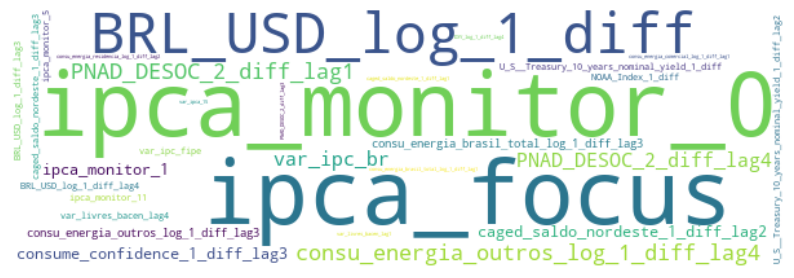

In [105]:
# Extracting the features with non-zero coefficients
features_most_frequent = top_features['Feature'].tolist()

# Joining all features into a single string for the word cloud
text = ' '.join(features_most_frequent)

# Generating the word cloud
wordcloud = WordCloud(width = 600, height = 200, background_color ='white').generate(text)

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axis for word cloud plots
plt.show()

### Coeficientes médios das 30 variáveis mais frequentes 

In [106]:
# Filtering the mean coefficients DataFrame to include only the top 30 most frequent features
top_features_mean_coefficients = mean_coefficients_sorted.merge(top_features[['Feature']], on='Feature')

# Sorting the resulting DataFrame by mean coefficient from highest to lowest
top_features_mean_coefficients_sorted = top_features_mean_coefficients.sort_values(by='Coefficient', ascending=False).reset_index(drop=True)

top_features_mean_coefficients_sorted.to_excel('mean_coefficients.xlsx')
top_features_mean_coefficients_sorted

,Feature,Coefficient
0,ipca_monitor_0,0.103643
1,var_ipc_fipe,0.088407
2,ipca_monitor_11,0.087756
3,ipca_focus,0.084531
4,ipca_monitor_1,0.083923
5,consu_energia_residencia_log_1_diff_lag2,0.071418
6,var_ipc_br,0.062890
7,var_ipca_15,0.052402
8,ipca_monitor_5,0.048060
9,BRL_USD_log_1_diff_lag4,0.036655


### Gráfico dos coeficientes médios das 30 variáveis mais frequentes

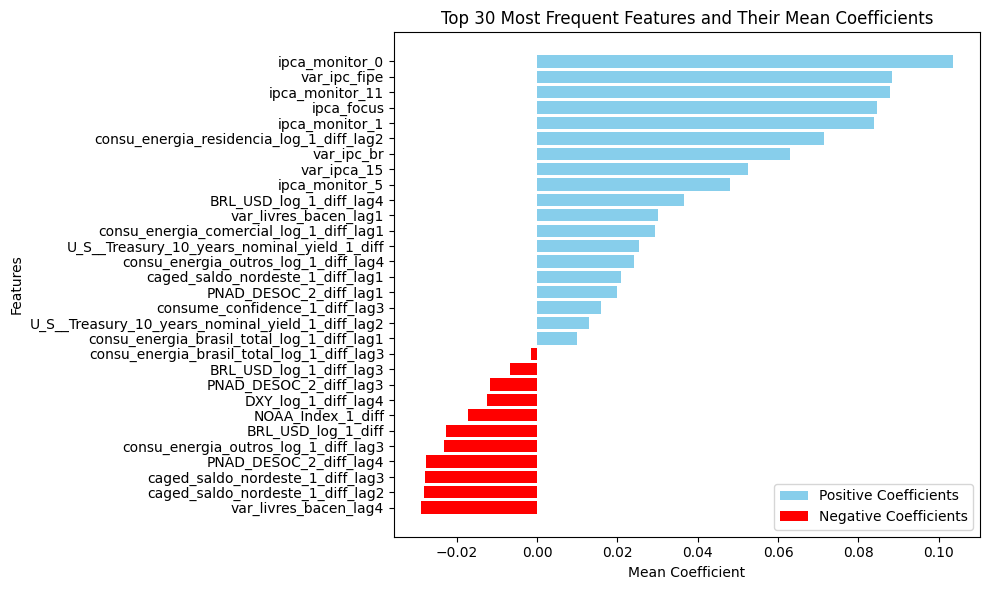

In [107]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'top_features_mean_coefficients_sorted' contains the DataFrame with top features and their mean coefficients

# Plotting the bar chart with different colors for positive and negative coefficients
plt.figure(figsize=(10, 6))
bars = plt.barh(top_features_mean_coefficients_sorted['Feature'][:30], top_features_mean_coefficients_sorted['Coefficient'][:30], color=['skyblue' if x >= 0 else 'red' for x in top_features_mean_coefficients_sorted['Coefficient'][:30]])
plt.xlabel('Mean Coefficient')
plt.ylabel('Features')
plt.title('Top 30 Most Frequent Features and Their Mean Coefficients')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest coefficient at the top

# Add a legend for positive and negative coefficients
plt.legend(handles=[bars[0], bars[-1]], labels=['Positive Coefficients', 'Negative Coefficients'])

plt.tight_layout()

# Save the plot as an image or display it
plt.savefig('mean_coefficients_bar_chart_with_colors.png')
plt.show()




## Discussão dos resutados da etapa 1 - Variáveis Selecionas usando o método RFE

Após executar o algoritmo RFE e obter as variáveis mais crucial ao longo do tempo, selecionamos as 30 variáveis mais frequentes que serão utilizadas em nossos modelos não lineares (AdaBoost, Gradient Boosting e Random Forest). O Gráfico e tabela acima mostram seus coeficientes médios através das amostras. Vinte deles representam dados de séries temporais associados à atividade econômica como o indicador de confiança do consumidor Fecomercio, consumo de energia, dados do mercado de trabalho, como CAGED e PNAD, clima (Índice NOAA), ou mercados financeiros como taxa de câmbio nominal (BRL/USD), Índice DXY e Tesouro dos EUA 10 anos. 

Vale a pena notar que todas essas variáveis apresentam diferentes níveis de desfasagem (representada pelo termo lagX), pois nas variáveis relacionadas com a atividade econômica, mercado de trabalho, clima ou mercados financeiros há inerentemente um alguam defasagem, mesmo quando a série temporal é contemporânea ao alvo a ser projetado (IPCA). Por exemplo, temos o indicador contemporâneo à meta da taxa de câmbio nominal (BRL/USD), do Tesouro dos EUA por 10 anos e do Índice DXY, mas a ElasticNet também selecionou seus valores defasados. Ademais, algumas variáveis não são divulgadas de forma contemporânea ao IPCA, como séries temporais relacionadas ao mercado de trabalho e ao consumo de energia. Essas variáveis com lag selecionadas alinham-se com a observação de que os modelos de inflação, particularmente em economias emergentes como o Brasil, deveriam incorporar uma rica estrutura de lags devido à inércia da inflação, conforme destacado por [Araujo & Gaglianone, 2023]. Além disso, indicadores econômicos específicos, como o consumo de energia e as taxas de câmbio, foram previamente identificados por [Özgür & Akkoç, 2021] na sua investigação sobre a previsão da inflação na Turquia utilizando métodos de redução para realizar uma seleção de variáveis, demonstrando a sua relevância em diferentes contextos. D

Dez variáveis selecionadas estão intimamente relacionadas à variável-alvo ou a outros indicadores de inflação no Brasil. Dentre eles, são significativos os subtipos de IPCA com diferentes lags como IPCA - preços não monitorados (IPCA - Livres) com defasagens de 1 e 4 períodos, e IPCA-15. Além disso, existem outras métricas mensais de inflação no Brasil, como o IPC-Br e o IPC-Fipe, divulgadas antes da nossa meta, sem qualquer defasagem. Essas variáveis são contemporâneas à meta e têm razoável importância na explicação da dinâmica da inflação no Brasil. Entre esses, o preditor mais frequente 'ipca_monitor_0', aparecendo em quase 69,2% dos meses da amostra e com o maior coeficiente médio, corresponde a uma série temporal derivada do "Monitor da Inflação". Aliás, muitas da variáveis usam dados do serviço "Monitor da Inflação", sendo que elas influenciaram significativamente o modelo com base em seus níveis de coeficientes. Para distinguí-los, incorporamos a string “monitor” em seus nomes. Esses indicadores são grupos do IPCA e o nível de importância delas reflete seu peso no IPCA. 

A segunda variável mais frequente, aparecendo em 59,6% de todas as amostras, é uma variável relacionada ao Focus (’ipca_focus’) para o nosso alvo é expectativa mediana do mercado para cada mês. Dado que esta variável é uma proxy do mercado para a inflação futura, não é surpreendente que seja altamente relevante devido à sua ocorrência frequente. Porém, de acordo com nossa abordagem, essa variável não possui o segundo maior coeficiente médio; esta posição é do IPC Fipe (’var_ipc_fipe’), outro índice de preços ao consumidor divulgado anteriormente à nossa meta (IPCA). Ao considerar o nível do coeficiente, ‘ipca_focus’ tem o quarto valor mais alto, não muito longe do segundo e terceiro valores mais altos. 

Quanto as variáveis relacionadas à atividade econômica há alguns detaques a mencionar, a taxa de desemprego possui três defasagens diferentes selecionadas pelo nosso método, mas a primeira e a quarta defasagens são as mais frequentes e possuem coeficientes médios em direções diferentes. Enquanto o ’PNAD_DESOC_2_diff_lag1’ apresenta coeficiente médio positivo, o ’PNAD_DESOC_2_diff_lag4’ apresenta valor negativo. Segundo a literatura que relaciona inflação e mercado de trabalho (taxa de desemprego na curva de Phillips, por exemplo), eles possuem uma relação  inversa. Em teoria, deveríamos ver apenas coeficientes negativos para esta variável, mas isso não aconteceu na nossa abordagem para a taxa de desemprego com uma defasagem (’PNAD_DESOC_2_diff_lag1’); as demais defasagens apresentam coeficiente negativo alinhado com a literatura. 

Ainda relativamente ao sinal dos coeficientes das variáveis, a maioria é positiva, conforme ilustrado no gráfico. Contudo, onze variáveis ​​apresentaram coeficiente negativos, sugerindo que aumentar uma e manter todas as outras estáveis ​​reduz o nível de inflação ao consumidor. Dezenove variáveis têm um coeficiente positivo, sugerindo que à medida que o valor da variável aumenta, a variável alvo também aumenta. Em outras palavras, os coeficientes positivos tendem a impactar diretamente os níveis de inflação. Por exemplo, a variável "ipca_monitor_0" possui um coeficiente médio de aproximadamente 0,10, indicando uma relação positiva com a variável alvo. Se todas as outras variáveis permanecerem constantes, um aumento nesta variável está associado a um aumento no valor previsto. Algumas das variáveis com valor de coeficiente positivo estão relacionadas à atividade econômica ou ao mercado de trabalho em diferentes defasagens, por exemplo, consumo de energia e Folha de Pagamento Caged. Um aumento nessas variáveis ​​pode indicar aumento da demanda agregada na economia brasileira, potencialmente levando ao aumento da inflação interna. 

É importante dizer que o IPCA com diferente lags foram identificadas como preditores significativos em testes anteriores. Esta análise preliminar indica que a incorporação de valores defasados ​​do IPCA poderia melhorar a precisão das previsões de inflação. No entanto, para o estágio atual do nosso estudo, optamos por excluir temporariamente essas variáveis defasadas. O lag do IPCA serão reintegrados em fases subsequentes, especialmente à medida que exploramos a previsão através de modelos não lineares, onde um conjunto mais amplo de metas desfasadas pode revelar-se benéfico.

Há um resultado curioso relacionado ao sinal do coeficiente cambial brasileiro. Esta variável sem defasagem ('BRL_USD_log_1_diff') e com três defasagens ('BRL_USD_log_1_diff_lag3') possui coeficiente negativo, mas a mesma variável com quatro defasagens ('BRL_USD_log_1_diff_lag4') possui coeficiente positivo. Esta situação sugere que a depreciação/apreciação da moeda nacional se correlaciona com taxas de inflação mais altas/mais baixas no Brasil com dinâmicas diferentes quando a variável  está em diferentes defasagens ou é contemporânea à meta. Um coeficiente positivo reforça uma correlação bem conhecida na literatura econômica que pode ser atribuída à sua influência direta nos custos dos bens importados e serviços. Esta situação realça a importância das taxas de câmbio na condução da inflação interna e na promoção de medidas proativas de política monetária.

# Modelos Não-Lineares

A partir das 30 séries selecionadas por meio das rotinas de seleção de variávies (Feature Selection) usando o algoritmo RFE que aplica o modelo ElasticNET, executamos os modelos não lineares para a previsão propriamente dita e avaliação dos resultados por meio do Shapley Value. 

## Objetivos

Nessa etapa do trabalho o objetivo é prever o IPCA usando modelos não-lineares baseados em árvores de decisão AdaBoost, Gradient Boosting e Random Forest. Para tanto são usadas as 30 variáveis selecionadas por meio do método RFE com ElasticNet. Também usamos o IPCA mensal com até 24 lags para realizar as projeções nesses modelos. Contudo, nos ajustes de hiperparamêtros para cada modelo seleciona-se diferentes especificações de defasagens do IPCA entre as 24 possíveis. Logo, para cada um deles há uma quantidade diferente de lags do IPCA.

### Carga das variáveis selecionadas na etapa de seleção das variáveis

In [ ]:
# troque esta variável para corresponder ao seu caso:
arquivo = "F:/Educacao/Pós Graduações e Graduações/Mestrado UNB/dissertacao/inflation_forecast_integration/03.feature_selection/dados.csv"

# importa dados
df = pd.read_csv(arquivo)

# define variável dependente
target = "var_ipca_bacen"

# drop unamed column
df = df.dropna(axis=1, how='all')

# preprocessamento
# cria index de tempo no dataframe do pandas
df['data'] = pd.to_datetime(df['data'])
df = df.set_index('data')
df = df.asfreq(pd.infer_freq(df.index))

# data para fim do conjuto de treinamento e validação
# o conjunto de teste começará após essa data, ou seja, é o último ano da série
# Partição 80/20, treino: 127 obs e teste: 32 obs
end_val = "2021-02-01 23:59:00"

#++++++++++++++++++++++++++
# Define the target variable and the features
target = 'var_ipca_bacen'
X = df.drop(target, axis=1)
y = df[target]

# Calculate the split point based on the desired percentage (e.g., 80% for training)
split_point = int(0.8 * len(X))

# Split the data into training and testing sets
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

n_observations_test_exog = X_test.shape[0]

# Check the shapes of the train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Optionally, you can check the first few rows of y_test and the last few rows of y_train
print("\nFirst few rows of y_test:")
print(y_test.head())

print("\nLast few rows of y_train:")
print(y_train.tail())

print("When does the test dataset start and finish?")
print("It starts:", y_test.head(1))

print("When does the test dataset start and finish?")
print("It finishes:", y_test.tail(1))

Gráfico da série temporal da variação mensal do IPCA, com destaque para a partição em subconjuntos de treinamento e teste.

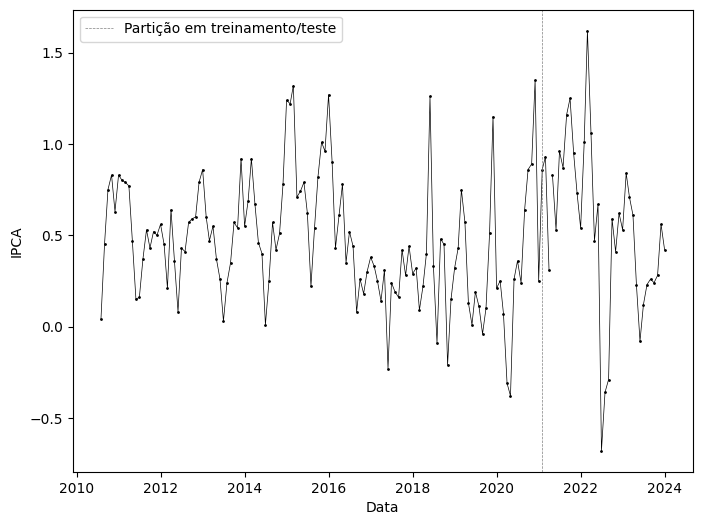

In [111]:
# visualiza série
plt.figure(figsize=(8, 6))

plt.plot(y_train, color = "black", linestyle='-', lw = 0.5, marker = '.', ms=2)
plt.plot(y_test, color = "black", linestyle='-', lw = 0.5, marker = '.', ms=2)
plt.axvline(x = pd.to_datetime(end_val), color = "gray", linestyle='--',
            lw = 0.5, label = 'Partição em treinamento/teste')
plt.ylabel('IPCA')
plt.xlabel('Data')
plt.legend()
plt.show()

### Ajuste dos hiperparamêtros (Grid Search)

In [112]:
cmap_cv = plt.cm.coolwarm
tscv = TimeSeriesSplit(n_splits = 5)#, test_size = 3)

In [114]:
# número de lags
n_lags = 24

# Lags used as predictors
lags_grid = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]

# conjunto de treino inicial no cross-validation: 60 meses
ini_train = 60

# a cada fold, o conjunto de validação avança 12 meses
val_step = 12

In [115]:
# random forest
rf = ForecasterAutoreg(
    regressor = RandomForestRegressor(random_state=123),
    transformer_exog = MinMaxScaler(),
    lags = n_lags # This value will be replaced in the grid search
  )

# grid de hiperparâmetros
rf_param_grid = {
    'n_estimators': [50, 100, 150, 200], # número de árvores na floresta
    'max_depth': [3, 5, 10, 15] # profundidade máxima das árvores
  }

# grid search
rf_results_grid = grid_search_forecaster(
    forecaster = rf,
    y = y_train,
    exog = X_train,
    param_grid = rf_param_grid,
    lags_grid = lags_grid,
    steps = val_step,
    metric = 'mean_squared_error',
    initial_train_size = ini_train,
    fixed_train_size = False,
    gap = 0,
    allow_incomplete_fold = True,
    refit = True,
    n_jobs = 'auto',
    verbose = False,
    show_progress = False,
    return_best = True,
  )

Number of models compared: 384.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 0.009445980615982749



In [116]:
rf_parametros = rf_results_grid.head(1)
rf_results_grid.to_csv('rf_parametros_grid_search.csv')

In [117]:
# AdaBoost
bst = ForecasterAutoreg(
    regressor = AdaBoostRegressor(random_state=123),
    transformer_exog = MinMaxScaler(),
    lags = n_lags # This value will be replaced in the grid search
  )

# grid de hiperparâmetros
bst_param_grid = {
    'n_estimators': [50, 100, 150, 200], #The maximum number of estimators at which boosting is terminated. In case of perfect fit, the learning procedure is stopped early. Values must be in the range
    'learning_rate': [0.001, 0.01, 0.1], #Weight applied to each regressor at each boosting iteration. A higher learning rate increases the contribution of each regressor. There is a trade-off between the learning_rate and n_estimators parameters. Values must be in the range (0.0, inf).
    'loss': ['linear', 'square', 'exponential'] #The loss function to use when updating the weights after each boosting iteration.
  }

# grid search
bst_results_grid = grid_search_forecaster(
    forecaster = bst,
    y = y_train,
    exog = X_train,
    param_grid = bst_param_grid,
    lags_grid = lags_grid,
    steps = val_step,
    metric = 'mean_squared_error',
    initial_train_size = ini_train,
    fixed_train_size = False,
    gap = 0,
    allow_incomplete_fold = True,
    refit = True,
    n_jobs = 'auto',
    verbose = False,
    show_progress = False,
    return_best = True,
  )

Number of models compared: 864.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 150}
  Backtesting metric: 0.00870500191678192



In [118]:
adaboost_parametros = bst_results_grid.head(1)
adaboost_parametros.to_csv('adaboost_parametros_grid_search.csv')

In [119]:
# Gradient Boosting
gbt = ForecasterAutoreg(
    regressor = GradientBoostingRegressor(random_state=123),
    transformer_exog = MinMaxScaler(),
    lags = n_lags # This value will be replaced in the grid search
  )

# grid de hiperparâmetros
gbt_param_grid = {
    'n_estimators': [50, 100, 150, 200], #he number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance. Values must be in the range [1, inf).
    'learning_rate': [0.001, 0.01, 0.1], #Learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators. Values must be in the range [0.0, inf).
    'max_depth': [3, 5, 10, 15] #Maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. Tune this parameter for best performance; the best value depends on the interaction of the input variables. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. If int, values must be in the range [1, inf).
  }

# grid search
gbt_results_grid = grid_search_forecaster(
    forecaster = gbt,
    y = y_train,
    exog = X_train,
    param_grid = gbt_param_grid,
    lags_grid = lags_grid,
    steps = val_step,
    metric = 'mean_squared_error',
    initial_train_size = ini_train,
    fixed_train_size = False,
    gap = 0,
    allow_incomplete_fold = True,
    refit = True,
    n_jobs = 'auto',
    verbose = False,
    show_progress = False,
    return_best = True,
  )

Number of models compared: 1152.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
  Backtesting metric: 0.006886970671770542



In [120]:
gb_parametros = gbt_results_grid.head(1)
gb_parametros.to_csv('gradient_boost_parametros_grid_search.csv')

In [121]:
# Extreme Gradient Boosting
xgb = ForecasterAutoreg(
    regressor = XGBRegressor(random_state=123),
    transformer_exog = MinMaxScaler(),
    lags = n_lags # This value will be replaced in the grid search
  )

# grid de hiperparâmetros
xgb_param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 5, 10, 15]
    #'reg_alpha':
    #'reg_lambda': 
  }

# grid search
xgb_results_grid = grid_search_forecaster(
    forecaster = xgb,
    y = y_train,
    exog = X_train,
    param_grid = xgb_param_grid,
    lags_grid = lags_grid,
    steps = val_step,
    metric = 'mean_squared_error',
    initial_train_size = ini_train,
    fixed_train_size = False,
    gap = 0,
    allow_incomplete_fold = True,
    refit = True,
    n_jobs = 'auto',
    verbose = False,
    show_progress = False,
    return_best = True,
  )

Number of models compared: 1152.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 150}
  Backtesting metric: 0.007926969128043167



In [122]:
xgb_parametros = xgb_results_grid.head(1)
xgb_parametros.to_csv('xgb_parametros_grid_search.csv')

In [123]:
5# tabela com os hiperparametros selecionados em cada modelo
df_treino = pd.concat([
rf_results_grid.head(1)[['lags','max_depth','n_estimators','mean_squared_error']],
bst_results_grid.head(1)[['lags','n_estimators','learning_rate','mean_squared_error','loss']],
gbt_results_grid.head(1)[['lags','max_depth','n_estimators','learning_rate','mean_squared_error']],
xgb_results_grid.head(1)[['lags','max_depth','n_estimators','learning_rate','mean_squared_error']]
])
df_treino['Modelo'] = ["Random Forest", "Adaptive Boosting", "Gradient Boosting", "Extreme Gradient Boosting"]
df_treino = df_treino[['Modelo','n_estimators','max_depth','learning_rate','mean_squared_error','loss']]
df_treino.rename(columns={'mean_squared_error': 'MSE'}, inplace=True)
df_treino.fillna('', inplace=True)
df_treino

,Modelo,n_estimators,max_depth,learning_rate,MSE,loss
21,Random Forest,100.0,5.0,,0.009446,
214,Adaptive Boosting,150.0,,0.1,0.008705,exponential
467,Gradient Boosting,200.0,3.0,0.1,0.006887,
90,Extreme Gradient Boosting,150.0,10.0,0.1,0.007927,


## Previsão

Após identificado os melhores hiperparamêtros, partimos para a previsão da variação mensal do IPCA propriamente dita. As previsões foram realizadas de forma recursiva e o conjunto de teste foi usado para avaliar a capacidade de generalização dos modelos. A Figura abaixo mostra os resultados das previsões com destaque para a comparação com o conjunto de teste.

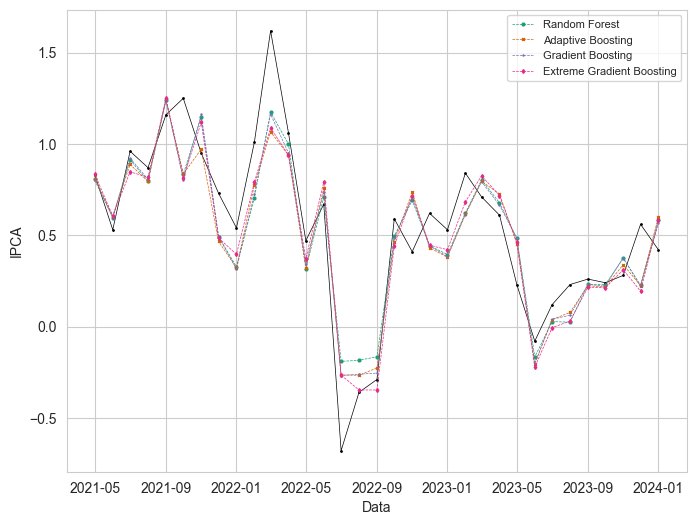

In [127]:
res_test = pd.DataFrame({
    "Conjunto de teste": y_test,
    "Random Forest": rf.predict(steps = n_observations_test_exog, exog = X_test),
    "Adaptive Boosting": bst.predict(steps = n_observations_test_exog, exog = X_test),
    "Gradient Boosting": gbt.predict(steps = n_observations_test_exog, exog = X_test),
    "Extreme Gradient Boosting": xgb.predict(steps = n_observations_test_exog, exog = X_test)
    })

# Save the results to a CSV file
res_test.to_csv('forecast_results.csv', index=False)

# visualiza previsao: apenas conjunto de teste
plt.figure(figsize=(8, 6))

plt.plot(y_test, color = "black", linestyle='-', lw = 0.5, marker = '.', ms=2)

plt.plot(res_test['Random Forest'], color = "#1b9e77", marker='o', linestyle='--',
         lw = 0.5, ms=2, label = "Random Forest")
plt.plot(res_test['Adaptive Boosting'], color = "#d95f02", marker='x', linestyle='--',
         lw = 0.5, ms=2, label = "Adaptive Boosting")
plt.plot(res_test['Gradient Boosting'], color = "#7570b3", marker='+', linestyle='--',
         lw = 0.5, ms=2, label = "Gradient Boosting")
plt.plot(res_test['Extreme Gradient Boosting'], color = "#e7298a", marker='d', linestyle='--',
         lw = 0.5, ms=2, label = "Extreme Gradient Boosting")

plt.ylabel('IPCA')
plt.xlabel('Data')
plt.legend(fontsize=8)
plt.show()

### Avaliação das previsões

As medidas de erro MSE, RMSE, MAE e MAPE foram usadas para a avaliar a capacidade de generalização dos modelos no conjunto de teste. A Tabela abaixo mostra os resultados das previsões dos modelos para as projeções no conjunto de teste. Em termos de MAE, o Gradient Boosting foi superior em comparação aos demais modelos, uma vez que obteve valores de MAE inferiores. Por outro lado, o Adaptive Boosting foi superior para MSE, RMSE e MAPE, uma vez que atingiu os menores valores nestas métricas.

In [128]:
rf_score = {"MAE": mean_absolute_error(y_test, res_test['Random Forest']),
            "MSE": mean_squared_error(y_test, res_test['Random Forest']),
            "RMSE": mean_squared_error(y_test, res_test['Random Forest'])**0.5,
            "MAPE": mean_absolute_percentage_error(y_test, res_test['Random Forest']),
            "R2": r2_score(y_test, res_test['Random Forest'])}

bst_score = {"MAE": mean_absolute_error(y_test, res_test['Adaptive Boosting']),
             "MSE": mean_squared_error(y_test, res_test['Adaptive Boosting']),
             "RMSE": mean_squared_error(y_test, res_test['Adaptive Boosting'])**0.5,
             "MAPE": mean_absolute_percentage_error(y_test, res_test['Adaptive Boosting']),
             "R2": r2_score(y_test, res_test['Adaptive Boosting'])}

gbt_score = {"MAE": mean_absolute_error(y_test, res_test['Gradient Boosting']),
             "MSE": mean_squared_error(y_test, res_test['Gradient Boosting']),
             "RMSE": mean_squared_error(y_test, res_test['Gradient Boosting'])**0.5,
             "MAPE": mean_absolute_percentage_error(y_test, res_test['Gradient Boosting']),
             "R2": r2_score(y_test, res_test['Gradient Boosting'])}

xgb_score = {"MAE": mean_absolute_error(y_test, res_test['Extreme Gradient Boosting']),
             "MSE": mean_squared_error(y_test, res_test['Extreme Gradient Boosting']),
             "RMSE": mean_squared_error(y_test, res_test['Extreme Gradient Boosting'])**0.5,
             "MAPE": mean_absolute_percentage_error(y_test, res_test['Extreme Gradient Boosting']),
             "R2": r2_score(y_test, res_test['Extreme Gradient Boosting'])}

score = pd.DataFrame.from_dict([rf_score, bst_score, gbt_score, xgb_score])
score.insert(loc=0, column='Modelo', value=["Random Forest", "Adaptive Boosting", "Gradient Boosting", "Extreme Gradient Boosting"])
score

,Modelo,MAE,MSE,RMSE,MAPE,R2
0,Random Forest,0.165995,0.042594,0.206384,0.347938,0.806984
1,Adaptive Boosting,0.163701,0.042528,0.206223,0.341531,0.807285
2,Gradient Boosting,0.161658,0.040787,0.201959,0.338590,0.815172
3,Extreme Gradient Boosting,0.162364,0.041717,0.204246,0.351238,0.810961


## Interpretação das previsões do modelo vencedor usando Shapley Value

Nesta etapa do trabalho aplicamos o método de explicabilidade de inteligência artifical independente de modelo chamado de Shapley Value. Tendo em vista que essa ferramenta usa muito recurso computacional, é boa prática aplicar o método somente ao modelo vencedor que em nosso caso é o Gradient Boosting.

In [131]:
#carrega e instala pacote.
#!pip install shap
import shap
shap.initjs()
from bcb import sgs
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('bmh')

# Captura os dados do IPCA %a.m.
ipca_index = sgs.get({'ipca' : 433}, start = '2000-01-01', end = '2023-12-31')
# Tratamento
## Retira o índice
ipca = ipca_index.reset_index()

In [132]:
gbt_results_grid = pd.read_csv("gradient_boost_parametros_grid_search.csv")
######################################
# automatiza lag do modelo vencedor #
######################################

# getting the lag hyperparameter from gradient boost model.
g = gbt_results_grid.head(1).iloc[:, 0].values.tolist() 

#############
# Gera Lags #
#############

# Criando lags para a variável dependente (target)
num_lags = 11  # You can adjust the number of lags as needed
#for column in ipca.columns:
for i in range(1, num_lags):
    ipca[f'var_ipca_bacen_lag_{i}'] = ipca['ipca'].shift(i)

# Slice the DataFrame based on the date range
ipca = ipca.set_index('Date')
ipca = ipca.loc['2010-08-01':'2024-01-01']
ipca = ipca.drop('ipca', axis=1)

ipca.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 161 entries, 2010-08-01 to 2023-12-01
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   var_ipca_bacen_lag_1   161 non-null    float64
 1   var_ipca_bacen_lag_2   161 non-null    float64
 2   var_ipca_bacen_lag_3   161 non-null    float64
 3   var_ipca_bacen_lag_4   161 non-null    float64
 4   var_ipca_bacen_lag_5   161 non-null    float64
 5   var_ipca_bacen_lag_6   161 non-null    float64
 6   var_ipca_bacen_lag_7   161 non-null    float64
 7   var_ipca_bacen_lag_8   161 non-null    float64
 8   var_ipca_bacen_lag_9   161 non-null    float64
 9   var_ipca_bacen_lag_10  161 non-null    float64
dtypes: float64(10)
memory usage: 13.8 KB


In [133]:
#del df  

arquivo = "F:/Educacao/Pós Graduações e Graduações/Mestrado UNB/dissertacao/inflation_forecast_integration/03.feature_selection/dados.csv"

# importa dados
df = pd.read_csv(arquivo)

# define variável dependente
target = "var_ipca_bacen"

# drop unamed column
df = df.dropna(axis=1, how='all')

# preprocessamento
# cria index de tempo no dataframe do pandas
df['data'] = pd.to_datetime(df['data'])
df = df.set_index('data')
df = df.asfreq(pd.infer_freq(df.index))

# Merge the two dataframes based on the index (date)
df = pd.merge(df, ipca, left_index=True, right_index=True, how='outer')
df.to_csv("ok.csv")

In [134]:
# Define the target variable and features
target = 'var_ipca_bacen'
X = df.drop(target, axis=1)
y = df[target]

# Scale the features
scaler = MinMaxScaler().set_output(transform="pandas")
X_scaled = scaler.fit_transform(X)

# Calculate the split point based on the desired percentage (e.g., 80% for training)
split_point = int(0.8 * len(X_scaled))

# Split the data into training and testing sets
X_train, X_test = X_scaled[:split_point], X_scaled[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

n_observations_test_exog = X_test.shape[0]

# Check the shapes of the train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Save the DataFrame to a CSV file
df.to_csv("df.csv")


X_train shape: (129, 40)
X_test shape: (33, 40)
y_train shape: (129,)
y_test shape: (33,)


In [135]:
# Assuming gbt_results_grid is a DataFrame containing results of a grid search
# and gbt_param_grid is the parameter grid used in the grid search

# Get the best parameters from gbt_results_grid
best_params = gbt_results_grid.head(1)[['max_depth', 'n_estimators', 'learning_rate']]
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])
# Convert best_params to a dictionary
best_params_dict = best_params.to_dict(orient='records')[0]
#best_params.to_csv('paramtros.csv')

In [136]:
# Fitting the model
best = GradientBoostingRegressor(random_state = 43,**best_params_dict).fit(X_train, y_train)
predicted_values = best.predict(X_train)
#predicted_values

In [137]:
# shap values
explainer = shap.TreeExplainer(best)
shap_values = explainer(X_train)

## SHAP Feature Importance / global prediction

### How can Shapley values explain global predictions?
In this part we will talk about the beeswarm plot and absolute mean Shapley values. Both of these plots can be obtained using the following code:
According to https://christophm.github.io/interpretable-ml-book/shap.html#shap  The idea behind SHAP feature importance is simple: Features with large absolute Shapley values are important. Since we want the global importance, we average the absolute Shapley values per feature across the data:

$$I_j=\frac{1}{n}\sum_{i=1}^n{}|\phi_j^{(i)}|$$

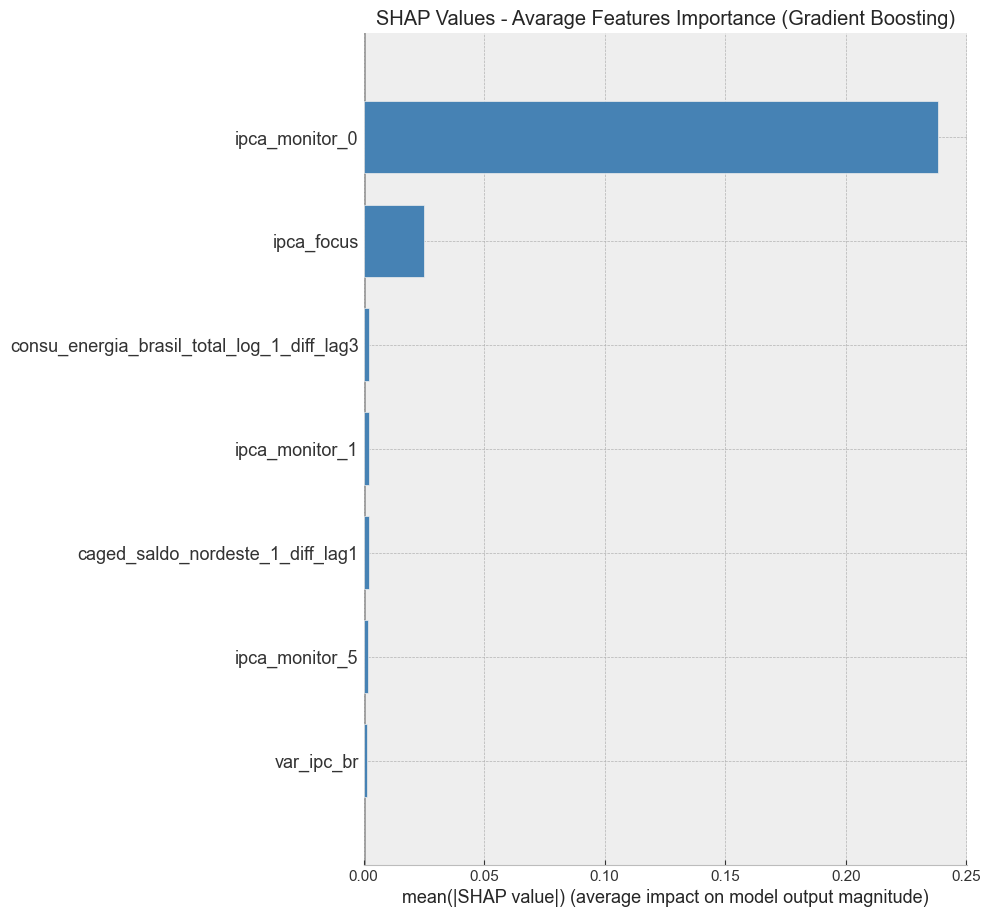

In [138]:
# gráfico do shap values com as 20 variáveis mais significativas para o melhor modelo (AdaBoost)
shap.summary_plot(shap_values, X_train, plot_type='bar', show=False, max_display=7, color='steelblue')
plt.title('SHAP Values - Avarage Features Importance (Gradient Boosting)')
plt.gcf().set_size_inches(12, 10)

Se queremos extrair alguma informação global a partir das importâncias locais, podemos usar o gráfico resumo (“summary plot”) do SHAP. Para o mesmo dataset, o seguinte gráfico pode ser obtido:

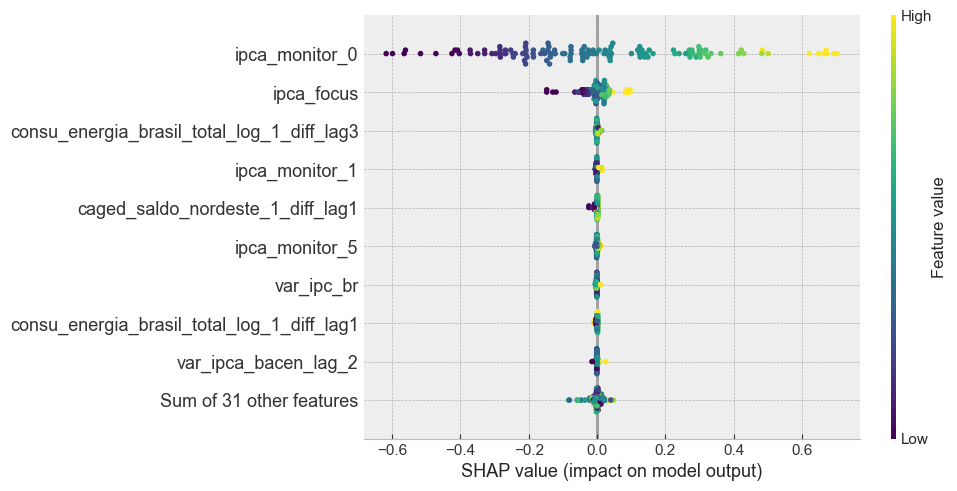

In [139]:
shap.plots.beeswarm(shap_values, color=plt.get_cmap('viridis'))

<Axes: xlabel='mean(|SHAP value|)'>

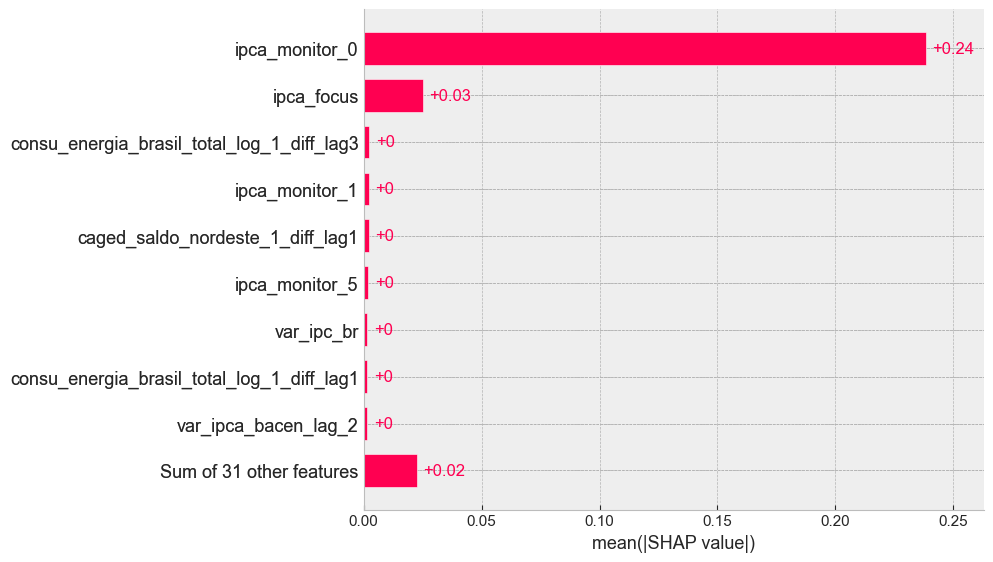

In [140]:
#matplotlib.pyplot.show()
# Plot the global Shapley values (x-axis=impact on model, y-axis=feature)
shap.plots.bar(shap_values, show=False)